# Load Data
Downloaded daily historical price data for ECH (iShares MSCI Chile ETF) from Yahoo Finance covering 2009–2020.

In [1]:
import yfinance as yf

# Download daily data from Dec 2009 to Jan 2020
ech = yf.download('ECH', start='2009-12-01', end='2020-01-31')
ech.to_csv('ech_data.csv')  # Optional save

/tmp/ipython-input-1-1300776824.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ech = yf.download('ECH', start='2009-12-01', end='2020-01-31')
[*********************100%***********************]  1 of 1 completed


# Calculate Dispersion Ratio
Computed the Dispersion Ratio using a 14-day rolling window:
standard deviation / mean of the closing price.



In [2]:
import pandas as pd

window = 14
ech['Dispersion_Ratio_Close'] = ech['Close'].rolling(window).std() / ech['Close'].rolling(window).mean()

In [3]:
ech.dropna(inplace=True)

# Create Target Variable
Generated a binary target:
1 if next day’s open > today’s open, else 0.

In [4]:
ech['Target'] = (ech['Open'].shift(-1) > ech['Open']).astype(int)
ech.dropna(inplace=True)

In [5]:
X = ech[['Dispersion_Ratio_Close']]
y = ech['Target']

# Normalize Feature
Applied Min-Max scaling to standardize the Dispersion Ratio for modeling.

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train Logistic Regression with 5-Fold Cross-Validation
Used 5-fold cross-validation to evaluate model performance. Reported average accuracy and standard deviation.

In [7]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

print(f"Average Accuracy: {sum(accuracies)/len(accuracies):.4f}")

Average Accuracy: 0.4868


# Results Table
Compiled a summary table showing the indicator used, model accuracy, and target definition.

In [9]:
import pandas as pd
import numpy as np

# Step 1: Compute mean and std of your accuracy scores
avg_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Step 2: Create the summary table as a Pandas DataFrame
results_table = pd.DataFrame({
    "Metric": ["Indicator", "Accuracy (avg)", "Std Dev", "Target"],
    "Value": ["Dispersion Ratio", f"{avg_accuracy:.4f}", f"{std_accuracy:.4f}", "Next-day Open Up/Down"]
})

# Step 3: Display it nicely
print(results_table)

           Metric                  Value
0       Indicator       Dispersion Ratio
1  Accuracy (avg)                 0.4868
2         Std Dev                 0.0183
3          Target  Next-day Open Up/Down


In [10]:
results_table.to_csv("results_summary.csv", index=False)

# Plot Indicator
Plotted the Dispersion Ratio over time to visualize volatility shifts across the period.

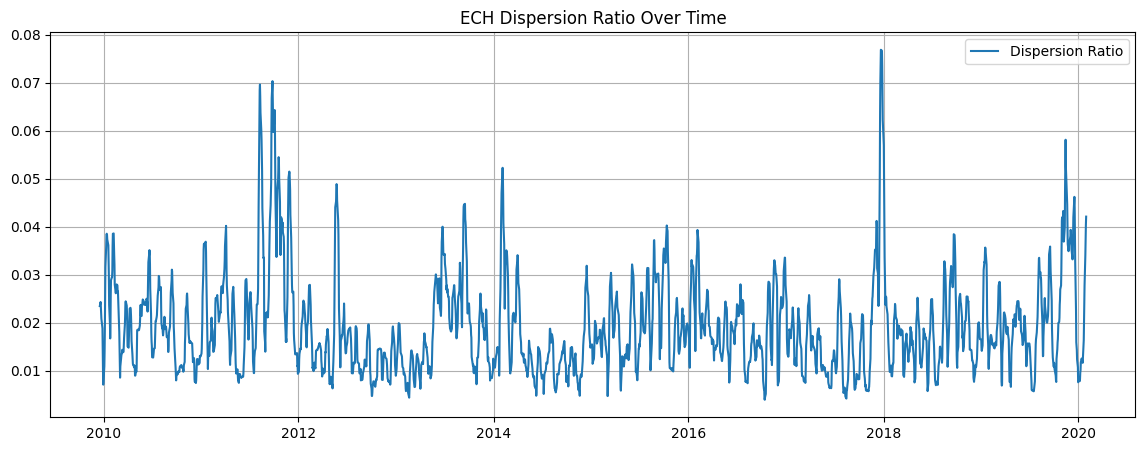

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(ech['Dispersion_Ratio_Close'], label='Dispersion Ratio')
plt.title('ECH Dispersion Ratio Over Time')
plt.legend()
plt.grid()
plt.show()